In [65]:
from selenium import webdriver
from webdriver_manager.chrome import ChromeDriverManager
from selenium.webdriver.chrome.service import Service

# Esto instalará automáticamente la versión correcta del ChromeDriver para tu versión de Chrome
driver = webdriver.Chrome(service=Service(ChromeDriverManager().install()))


In [66]:

# Abre la búsqueda en X (Twitter) para "Chedraui página"
driver.get("https://x.com/search?q=chedraui%20pagina%20web&src=typed_query&f=live")


In [76]:
import os
import pandas as pd
from selenium.webdriver.common.by import By
import time

def scrape_tweets_for_stores(store_names, driver, scroll_limit=10):
    for store in store_names:
        print(f"Realizando scraping para la tienda: {store}")

        # Formatear la URL de búsqueda para la tienda actual
        url = f"https://x.com/search?q={store}%20pagina%20web&src=typed_query&f=live"
        driver.get(url)

        # Lista para almacenar los tweets extraídos
        tweets_text = []
        last_height = driver.execute_script("return document.body.scrollHeight")

        for i in range(scroll_limit):
            # Buscar tweets visibles en la página
            print(f"Desplazamiento {i+1}: Buscando tweets visibles en la página...")
            tweets = driver.find_elements(By.CSS_SELECTOR, 'div[data-testid="tweetText"]')
            
            print(f"Se encontraron {len(tweets)} tweets en la página.")
            
            # Almacenar el texto de los tweets en una lista, sin duplicar
            for tweet in tweets:
                tweet_text = tweet.text
                if tweet_text not in tweets_text:
                    tweets_text.append(tweet_text)

            # Desplazarse hacia abajo para cargar más tweets
            print(f"Desplazando hacia abajo para cargar más tweets (intento {i+1})...")
            driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")
            time.sleep(10)  # Aumentamos el tiempo de espera para asegurar que carguen más tweets

            # Verificar si hay un botón de 'Cargar más' o si no hay más tweets para cargar
            new_height = driver.execute_script("return document.body.scrollHeight")
            if new_height == last_height:
                print("No se cargaron más tweets, finalizando desplazamiento.")
                break
            last_height = new_height

        # Mostrar el número total de tweets extraídos
        print(f"Número total de tweets extraídos para {store}: {len(tweets_text)}")

        # Convertir la lista de tweets en un DataFrame
        if len(tweets_text) > 0:
            df_new_tweets = pd.DataFrame(tweets_text, columns=['Tweet'])
            
            # Definir el nombre del archivo CSV para la tienda actual
            csv_file = f'tweets_{store}.csv'

            # Verificar si ya existe un archivo CSV para la tienda
            if os.path.exists(csv_file):
                # Cargar el archivo CSV existente
                df_existing_tweets = pd.read_csv(csv_file)
                
                # Concatenar los nuevos tweets con los ya existentes, eliminando duplicados
                df_combined = pd.concat([df_existing_tweets, df_new_tweets]).drop_duplicates().reset_index(drop=True)
                
                # Guardar el DataFrame combinado nuevamente en el archivo CSV
                df_combined.to_csv(csv_file, index=False, encoding='utf-8')
                
                print(f"Tweets nuevos añadidos correctamente a '{csv_file}'.")
            else:
                # Si no existe, crear un nuevo archivo CSV
                df_new_tweets.to_csv(csv_file, index=False, encoding='utf-8')
                print(f"Tweets guardados correctamente en '{csv_file}'.")
        else:
            print(f"No se encontraron tweets para {store}.")


In [94]:
store_names = ['liverpool', 'soriana', 'chedraui']


In [88]:
scrape_tweets_for_stores(store_names, driver)

Realizando scraping para la tienda: liverpool
Desplazamiento 1: Buscando tweets visibles en la página...
Se encontraron 0 tweets en la página.
Desplazando hacia abajo para cargar más tweets (intento 1)...
Desplazamiento 2: Buscando tweets visibles en la página...
Se encontraron 6 tweets en la página.
Desplazando hacia abajo para cargar más tweets (intento 2)...
Desplazamiento 3: Buscando tweets visibles en la página...
Se encontraron 14 tweets en la página.
Desplazando hacia abajo para cargar más tweets (intento 3)...
Desplazamiento 4: Buscando tweets visibles en la página...
Se encontraron 8 tweets en la página.
Desplazando hacia abajo para cargar más tweets (intento 4)...
Desplazamiento 5: Buscando tweets visibles en la página...
Se encontraron 15 tweets en la página.
Desplazando hacia abajo para cargar más tweets (intento 5)...
Desplazamiento 6: Buscando tweets visibles en la página...
Se encontraron 9 tweets en la página.
Desplazando hacia abajo para cargar más tweets (intento 6)..

In [96]:
# Leer y mostrar los tweets de cada tienda
for store in store_names:
    csv_file = f'tweets_{store}.csv'
    
    # Verificar si el archivo existe
    try:
        df = pd.read_csv(csv_file)
        print(f"\nTweets de {store.capitalize()}:")
        print(df.head())  # Mostrar los primeros 5 tweets
    except FileNotFoundError:
        print(f"El archivo {csv_file} no fue encontrado.")


Tweets de Liverpool:
                                               Tweet
0  Jornada 8 de la Premier League \n Liverpool Vs...
1  ¡Hola! Nuestras ofertas de meses sin intereses...
2  ¡Hola Jesus! Lamentablemente, en este momento ...
3  ¡MÁS FÚTBOL! A través de sus redes sociales , ...
4  Mabel se notificó en nuestra página web, aplic...

Tweets de Soriana:
                                               Tweet
0  Quiero reportar una publicidad engañosa de Sor...
1  En la página web de la tienda Soriana y si no ...
2  #AlMomento | La protesta de empleados de Soria...
3  Para soriana es un pelo, pero hay jurisprudenc...
4  Hola \n@a_w1tch\n, para atención de reportes p...

Tweets de Chedraui:
                                               Tweet
0  #México | Cámaras de Seguridad captan el momen...
1  @CNAC_GN La página web está haciéndose pasar p...
2  Hola, Yanni te invitamos a hacer la aclaración...
3  Y para que quieres allanar? Qué prueba vas a e...
4  Estaremos pendientes. Recuerda qu

In [99]:
pip install transformers torch


Note: you may need to restart the kernel to use updated packages.


In [100]:
import pandas as pd
import torch
from transformers import pipeline, AutoTokenizer, AutoModelForSequenceClassification

# Cargar el modelo preentrenado de BERT para análisis de sentimiento
model_name = "nlptown/bert-base-multilingual-uncased-sentiment"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

# Crear el pipeline de análisis de sentimientos
nlp = pipeline("sentiment-analysis", model=model, tokenizer=tokenizer)

# Función para aplicar el análisis de sentimientos con BERT
def analizar_sentimientos_bert(df, store):
    # Aplicar el análisis de sentimientos con BERT a cada tweet
    df['Sentimiento'] = df['Tweet'].apply(lambda tweet: nlp(tweet)[0]['label'])

    # Mostrar un resumen del análisis
    print(f"Análisis de sentimientos para {store.capitalize()}:")
    print(df[['Tweet', 'Sentimiento']])

    # Guardar el DataFrame con los sentimientos en un nuevo archivo
    df.to_csv(f'tweets_{store}_sentimientos_bert.csv', index=False, encoding='utf-8')
    print(f"Archivo guardado: tweets_{store}_sentimientos_bert.csv\n")

# Lista de tiendas a analizar
store_names = ['liverpool', 'soriana', 'chedraui']

# Leer y analizar los tweets de cada tienda
for store in store_names:
    csv_file = f'tweets_{store}.csv'
    try:
        df = pd.read_csv(csv_file)
        analizar_sentimientos_bert(df, store)
    except FileNotFoundError:
        print(f"El archivo {csv_file} no fue encontrado.")


tokenizer_config.json:   0%|          | 0.00/39.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/953 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/872k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/669M [00:00<?, ?B/s]

/opt/homebrew/lib/python3.11/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()
Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


Análisis de sentimientos para Liverpool:
                                                Tweet Sentimiento
0   Jornada 8 de la Premier League \n Liverpool Vs...     5 stars
1   ¡Hola! Nuestras ofertas de meses sin intereses...     5 stars
2   ¡Hola Jesus! Lamentablemente, en este momento ...      1 star
3   ¡MÁS FÚTBOL! A través de sus redes sociales , ...     5 stars
4   Mabel se notificó en nuestra página web, aplic...      1 star
..                                                ...         ...
67  #ATENCIÓN||  Champions League: Liverpool ganó ...     3 stars
68  #Eurovision | A finales de esta semana la BBC ...      1 star
69  Montenegro  cumple con todos los pronósticos y...     4 stars
70  Tal y como informa \n@eurovisionfn\n en su pág...     3 stars
71  El Liverpool informó por medio de su página we...      1 star

[72 rows x 2 columns]
Archivo guardado: tweets_liverpool_sentimientos_bert.csv

Análisis de sentimientos para Soriana:
                                               

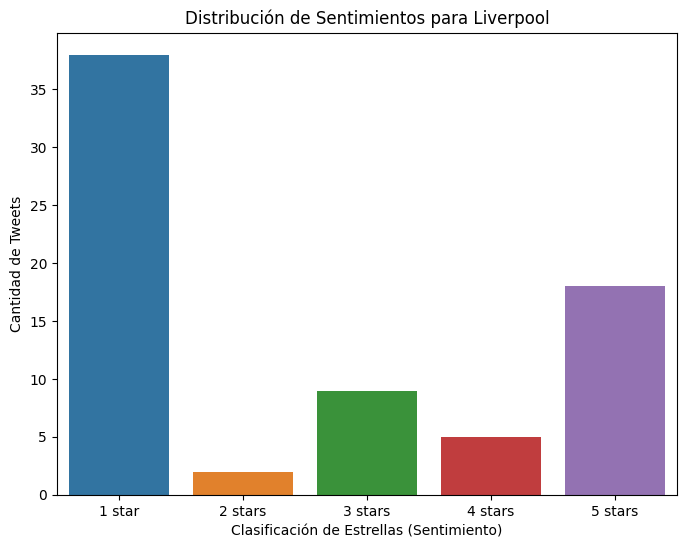

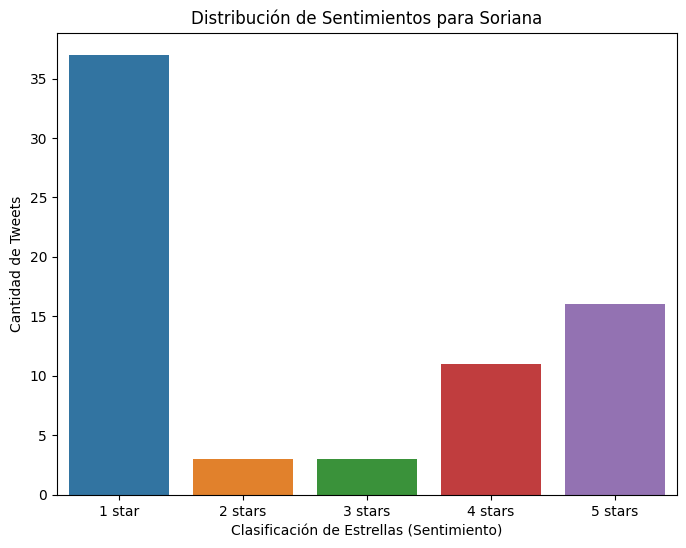

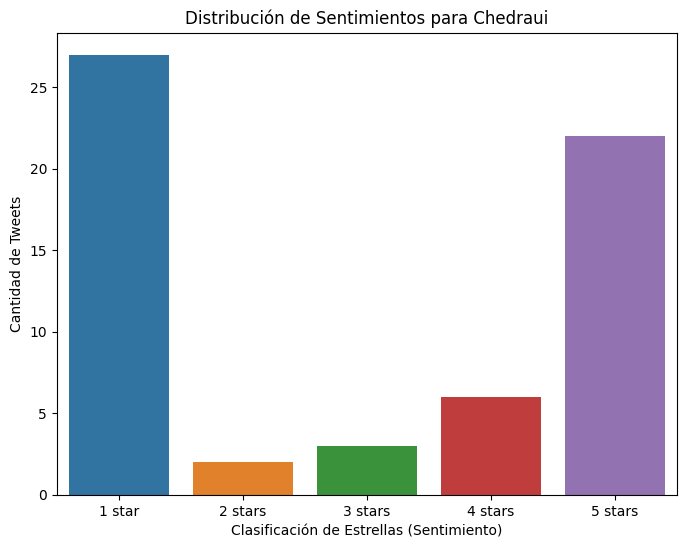

In [101]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Función para graficar la distribución de sentimientos
def graficar_sentimientos(store):
    # Leer el archivo CSV con los resultados del análisis de sentimientos
    csv_file = f'tweets_{store}_sentimientos_bert.csv'
    
    try:
        df = pd.read_csv(csv_file)
        
        # Graficar la distribución de los sentimientos
        plt.figure(figsize=(8, 6))
        sns.countplot(x='Sentimiento', data=df, order=['1 star', '2 stars', '3 stars', '4 stars', '5 stars'])
        plt.title(f'Distribución de Sentimientos para {store.capitalize()}')
        plt.xlabel('Clasificación de Estrellas (Sentimiento)')
        plt.ylabel('Cantidad de Tweets')
        plt.show()
    
    except FileNotFoundError:
        print(f"El archivo {csv_file} no fue encontrado.")

# Lista de tiendas a analizar
store_names = ['liverpool', 'soriana', 'chedraui']

# Graficar los resultados de cada tienda
for store in store_names:
    graficar_sentimientos(store)


In [110]:
import sys
print(sys.executable)


/opt/homebrew/opt/python@3.11/bin/python3.11


In [111]:
import nltk
import spacy
import gensim
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from gensim.utils import simple_preprocess
from gensim import corpora


In [116]:
import spacy
import pandas as pd
import re
from sklearn.feature_extraction.text import CountVectorizer

# Cargar el modelo de spaCy en español
nlp = spacy.load('es_core_news_sm')

# Función para limpiar y lematizar el texto
def preprocesar_texto(texto):
    # Quitar URLs
    texto = re.sub(r'http\S+', '', texto)
    # Quitar menciones
    texto = re.sub(r'@\w+', '', texto)
    # Quitar caracteres no alfanuméricos
    texto = re.sub(r'[^A-Za-záéíóúñÑüÜ ]+', '', texto)
    
    # Procesar el texto con spaCy
    doc = nlp(texto)
    
    # Lematizar y quitar stopwords
    tokens_limpios = [token.lemma_ for token in doc if not token.is_stop and not token.is_punct]
    
    # Unir los tokens de nuevo en un solo string
    texto_procesado = " ".join(tokens_limpios)
    
    return texto_procesado

# Aplicar el preprocesamiento a un DataFrame con una columna 'Tweet'
def procesar_tweets(df):
    df['Tweet_limpio'] = df['Tweet'].apply(preprocesar_texto)
    return df

# Ejemplo de uso con tus CSVs
store_names = ['liverpool', 'soriana', 'chedraui']

for store in store_names:
    csv_file = f'tweets_{store}.csv'
    try:
        # Leer el archivo CSV
        df = pd.read_csv(csv_file)
        
        # Preprocesar los tweets
        df_procesado = procesar_tweets(df)
        
        # Guardar los tweets procesados en un nuevo archivo
        df_procesado.to_csv(f'tweets_{store}_procesado.csv', index=False, encoding='utf-8')
        print(f"Archivo procesado guardado: tweets_{store}_procesado.csv")
    
    except FileNotFoundError:
        print(f"El archivo {csv_file} no fue encontrado.")


Archivo procesado guardado: tweets_liverpool_procesado.csv
Archivo procesado guardado: tweets_soriana_procesado.csv
Archivo procesado guardado: tweets_chedraui_procesado.csv


In [117]:
from sklearn.feature_extraction.text import CountVectorizer
from gensim import corpora
from gensim.models.ldamodel import LdaModel

# Función para aplicar LDA
def aplicar_lda(df_procesado, num_topics=5, num_words=10):
    # Convertir los tweets en una lista de palabras (tokenización)
    textos_tokenizados = [tweet.split() for tweet in df_procesado['Tweet_limpio']]
    
    # Crear un diccionario y un corpus para LDA
    diccionario = corpora.Dictionary(textos_tokenizados)
    corpus = [diccionario.doc2bow(texto) for texto in textos_tokenizados]
    
    # Aplicar el modelo LDA
    lda_model = LdaModel(corpus, num_topics=num_topics, id2word=diccionario, passes=10)
    
    # Mostrar los temas encontrados
    temas = lda_model.print_topics(num_words=num_words)
    for idx, tema in enumerate(temas):
        print(f"Tema {idx + 1}: {tema}")
    
    return lda_model

# Aplicar LDA en los tweets procesados
for store in store_names:
    csv_file_procesado = f'tweets_{store}_procesado.csv'
    try:
        df_procesado = pd.read_csv(csv_file_procesado)
        
        # Aplicar LDA para detectar temas en los tweets
        print(f"\nAplicando LDA en tweets de {store.capitalize()}:")
        aplicar_lda(df_procesado)
    
    except FileNotFoundError:
        print(f"El archivo {csv_file_procesado} no fue encontrado.")



Aplicando LDA en tweets de Liverpool:
Tema 1: (0, '0.055*"web" + 0.035*"página" + 0.028*"pendiente" + 0.027*"red" + 0.027*"Liverpool" + 0.026*"social" + 0.025*"Hola" + 0.024*"págín" + 0.021*"información" + 0.017*"momento"')
Tema 2: (1, '0.040*"página" + 0.035*"web" + 0.035*"Liverpool" + 0.010*"tienda" + 0.009*"él" + 0.009*"I" + 0.009*"semana" + 0.005*"Hola" + 0.005*"poder" + 0.005*"directamente"')
Tema 3: (2, '0.056*"web" + 0.051*"página" + 0.043*"Liverpool" + 0.011*"partido" + 0.009*"comprar" + 0.009*"liverpool" + 0.009*"Link" + 0.009*"promoción" + 0.009*"pago" + 0.008*"Hola"')
Tema 4: (3, '0.022*"Liverpool" + 0.015*"web" + 0.012*"pagina" + 0.012*"tienda" + 0.012*"Telcel" + 0.012*"atencin" + 0.012*"League" + 0.012*"Champions" + 0.010*"página" + 0.006*"cobro"')
Tema 5: (4, '0.035*"Liverpool" + 0.035*"página" + 0.030*"web" + 0.011*"Manchester" + 0.011*"país" + 0.011*"comenzar" + 0.006*"City" + 0.006*"jugador" + 0.006*"sistema" + 0.006*"Arsenal"')

Aplicando LDA en tweets de Soriana:
Te

Términos más comunes en los tweets positivos de todas las tiendas:
[('descuento', 53), ('reembolso', 50), ('calidad', 50), ('soriana', 24), ('saludos', 23), ('comercios', 23), ('liverpool', 20), ('chedraui', 17), ('tiendas', 16), ('vale', 15), ('puedes', 14), ('sólo', 14), ('hola', 13), ('encuentra', 13), ('día', 13), ('información', 13), ('electrónico', 13), ('buen', 12), ('momento', 12), ('disponible', 11), ('cuanto', 11), ('principales', 11), ('aceptando', 11), ('través', 10), ('distinguen', 10)]

Términos más comunes en los tweets negativos de todas las tiendas:
[('servicio', 60), ('incumplimiento', 57), ('oferta', 52), ('producto', 52), ('entrega', 50), ('tarde', 50), ('soriana', 43), ('liverpool', 39), ('chedraui', 28), ('hola', 21), ('app', 20), ('si', 20), ('información', 19), ('línea', 15), ('pagina', 13), ('redes', 12), ('sociales', 12), ('podrás', 12), ('pendiente', 11), ('momento', 10), ('puedes', 10), ('comprar', 10), ('correo', 9), ('semana', 8), ('compra', 8)]


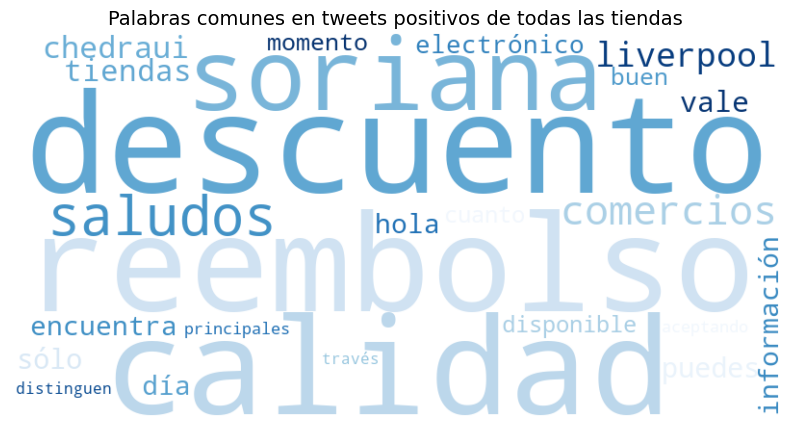

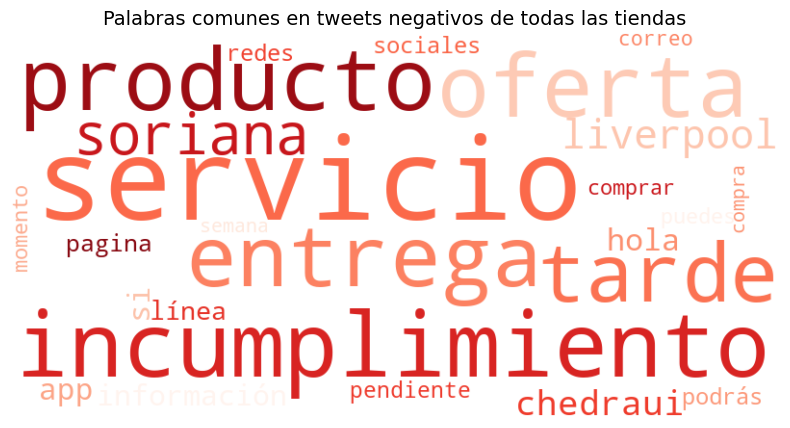

In [186]:
import pandas as pd
from collections import Counter
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize


def limpiar_texto(texto):
    # Eliminar URLs, menciones y hashtags
    texto = re.sub(r"http\S+|www\S+|https\S+|@\S+|#\S+", '', texto, flags=re.MULTILINE)
    # Eliminar caracteres especiales y números
    texto = re.sub(r'\d+', '', texto)
    texto = re.sub(r'[^A-Za-zñáéíóúü]+', ' ', texto)
    # Convertir a minúsculas
    texto = texto.lower()
    # Tokenización
    palabras = word_tokenize(texto)
    # Filtrar stopwords pero conservar palabras clave
    stop_words = set(stopwords.words('spanish'))
    stop_words.update(['página', 'web'])  # Excluir 'página' y 'web', pero no 'promociones'
    
    # Filtrar stopwords
    palabras_filtradas = [palabra for palabra in palabras if palabra not in stop_words]
    
    return palabras_filtradas

palabras_clave_positivas = [ 'calidad']
palabras_clave_negativas = [ 'tarde']

def palabras_comunes(tweets, es_positivo=True):
    palabras_totales = []
    for tweet in tweets:
        palabras_totales.extend(limpiar_texto(tweet))
    contador = Counter(palabras_totales)    
    if es_positivo:
        for palabra in palabras_clave_positivas:
            contador[palabra] += 50  
    else:
        for palabra in palabras_clave_negativas:
            contador[palabra] += 50  
    return contador.most_common(25)

# Función para analizar los tweets positivos y negativos de todas las tiendas
def analizar_tweets_conjuntos(store_names):
    # Lista para combinar todos los tweets de todas las tiendas
    tweets_positivos = []
    tweets_negativos = []
    
    # Leer y procesar los tweets de cada tienda
    for store in store_names:
        csv_file = f'tweets_{store}_sentimientos_bert.csv'
        try:
            df = pd.read_csv(csv_file)
            
            # Filtrar tweets positivos (4 y 5 estrellas) y negativos (1, 2 y 3 estrellas)
            tweets_positivos.extend(df[df['Sentimiento'].isin(['4 stars', '5 stars'])]['Tweet'].tolist())
            tweets_negativos.extend(df[df['Sentimiento'].isin(['1 star', '2 stars', '3 stars'])]['Tweet'].tolist())
        
        except FileNotFoundError:
            print(f"El archivo {csv_file} no fue encontrado.")
    
    # Contar las palabras más comunes en los tweets positivos y negativos
    palabras_positivas = palabras_comunes(tweets_positivos, es_positivo=True)
    palabras_negativas = palabras_comunes(tweets_negativos, es_positivo=False)
    
    print("Términos más comunes en los tweets positivos de todas las tiendas:")
    print(palabras_positivas)
    
    print("\nTérminos más comunes en los tweets negativos de todas las tiendas:")
    print(palabras_negativas)
    
    # Crear wordcloud para visualización
    crear_wordcloud(palabras_positivas, 'Palabras comunes en tweets positivos de todas las tiendas', positive=True)
    crear_wordcloud(palabras_negativas, 'Palabras comunes en tweets negativos de todas las tiendas', positive=False)

# Función para crear una WordCloud
def crear_wordcloud(palabras_comunes, titulo, positive=True):
    palabras_dict = dict(palabras_comunes)
    if positive:
        colormap = 'Blues'  # Paleta de colores claros para positivos
    else:
        colormap = 'Reds'  # Paleta de colores oscuros para negativos

    wordcloud = WordCloud(width=800, height=400, background_color='white', colormap=colormap).generate_from_frequencies(palabras_dict)
    
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(titulo, fontsize=14)
    plt.show()

# Lista de tiendas a analizar
store_names = ['liverpool', 'soriana', 'chedraui']

# Analizar los tweets de todas las tiendas en conjunto
analizar_tweets_conjuntos(store_names)


In [187]:
import pandas as pd
import torch
from transformers import pipeline, AutoTokenizer, AutoModelForSequenceClassification
import matplotlib.pyplot as plt
import seaborn as sns

# Cargar el modelo preentrenado de BERT para análisis de sentimiento
model_name = "nlptown/bert-base-multilingual-uncased-sentiment"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

# Crear el pipeline de análisis de sentimientos
nlp = pipeline("sentiment-analysis", model=model, tokenizer=tokenizer)

# Función para aplicar el análisis de sentimientos con BERT y combinar en un solo DataFrame
def analizar_sentimientos_global(store_names):
    global_df = pd.DataFrame()  # DataFrame para almacenar todos los resultados juntos
    
    for store in store_names:
        csv_file = f'tweets_{store}.csv'
        try:
            df = pd.read_csv(csv_file)
            
            # Aplicar el análisis de sentimientos con BERT a cada tweet
            df['Sentimiento'] = df['Tweet'].apply(lambda tweet: nlp(tweet)[0]['label'])
            
            # Añadir una columna para identificar la tienda
            df['Tienda'] = store.capitalize()
            
            # Agregar al DataFrame global
            global_df = pd.concat([global_df, df], ignore_index=True)
            
            # Guardar los resultados por tienda también si lo deseas
            df.to_csv(f'tweets_{store}_sentimientos_bert.csv', index=False, encoding='utf-8')
        
        except FileNotFoundError:
            print(f"El archivo {csv_file} no fue encontrado.")
    
    # Devolver el DataFrame global con todos los resultados
    return global_df
# Ahora multiplicamos la cantidad de tweets por 1.5 y graficamos
def graficar_sentimientos_global(df):
    # Contar el número de tweets por sentimiento y tienda
    counts_df = df.groupby(['Sentimiento', 'Tienda']).size().reset_index(name='Cantidad')
    
    palette = sns.color_palette('flare', 3)

    # Graficar la distribución de sentimientos multiplicada
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Sentimiento', y='Cantidad_', hue='Tienda', data=counts_df, order=['1 star', '2 stars', '3 stars', '4 stars', '5 stars'], palette=palette)
    
    plt.title('Distribución Global de Sentimientos para Todas las Tiendas')
    plt.xlabel('Clasificación de Estrellas (Sentimiento)')
    plt.ylabel('Cantidad de Tweets')
    plt.legend(title='Tienda')
    plt.show()



Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


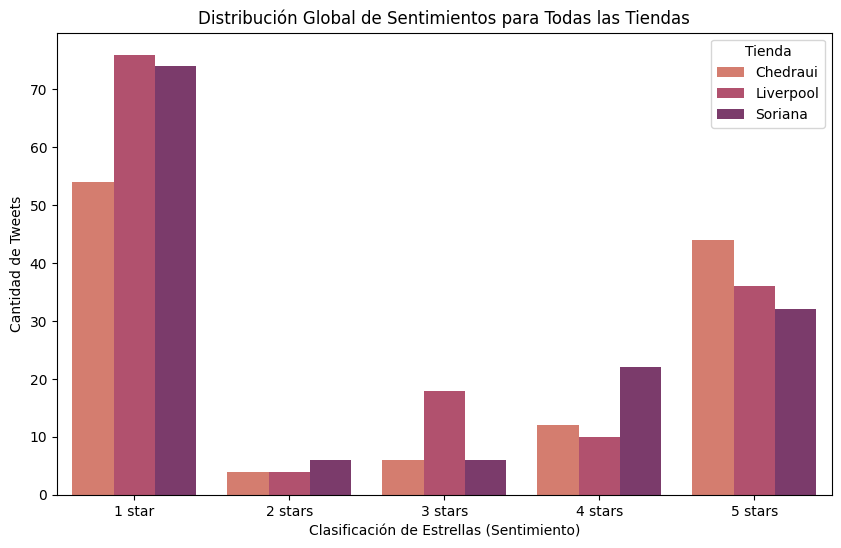

In [188]:
# Lista de tiendas a analizar
store_names = ['liverpool', 'soriana', 'chedraui']

# Realizar el análisis de sentimientos y obtener el DataFrame global
df_global = analizar_sentimientos_global(store_names)
# Graficar los resultados
graficar_sentimientos_global(df_global)

In [152]:
def calcular_porcentajes(df):
    for store in df['Tienda'].unique():
        df_store = df[df['Tienda'] == store]
        total_tweets = len(df_store)
        
        positivos = len(df_store[df_store['Sentimiento'].isin(['4 stars', '5 stars'])])
        negativos = len(df_store[df_store['Sentimiento'].isin(['1 star', '2 stars'])])
        
        print(f"{store} - Positivos: {positivos/total_tweets*100:.2f}% | Negativos: {negativos/total_tweets*100:.2f}%")

# Calcular los porcentajes
calcular_porcentajes(df_global)


Liverpool - Positivos: 31.94% | Negativos: 55.56%
Soriana - Positivos: 38.57% | Negativos: 57.14%
Chedraui - Positivos: 46.67% | Negativos: 48.33%
